# Practical session n°5:

##Part I: Quantile Regression with Neural networks.

* Adapted Cost Function
* Two examples with FCN
* A simultaneous quantile regression

##Part II: Sampling with GANs.

* Basic Principle and First Training
* Limitations
* A Wasserstein GAN

Duration: 4 hours

### Partie I: quantile regression   

In this part, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms


In [2]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 399 (delta 122), reused 141 (delta 93), pack-reused 210
Receiving objects: 100% (399/399), 77.81 MiB | 30.84 MiB/s, done.
Resolving deltas: 100% (162/162), done.


**Exercise 1**: an adapted cost function

As seen in the previous practical session n°3, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

In [3]:
os.chdir('ml-student/TP3/')
from utile import gen_proba

In [4]:
os.listdir('.')
from utile import *

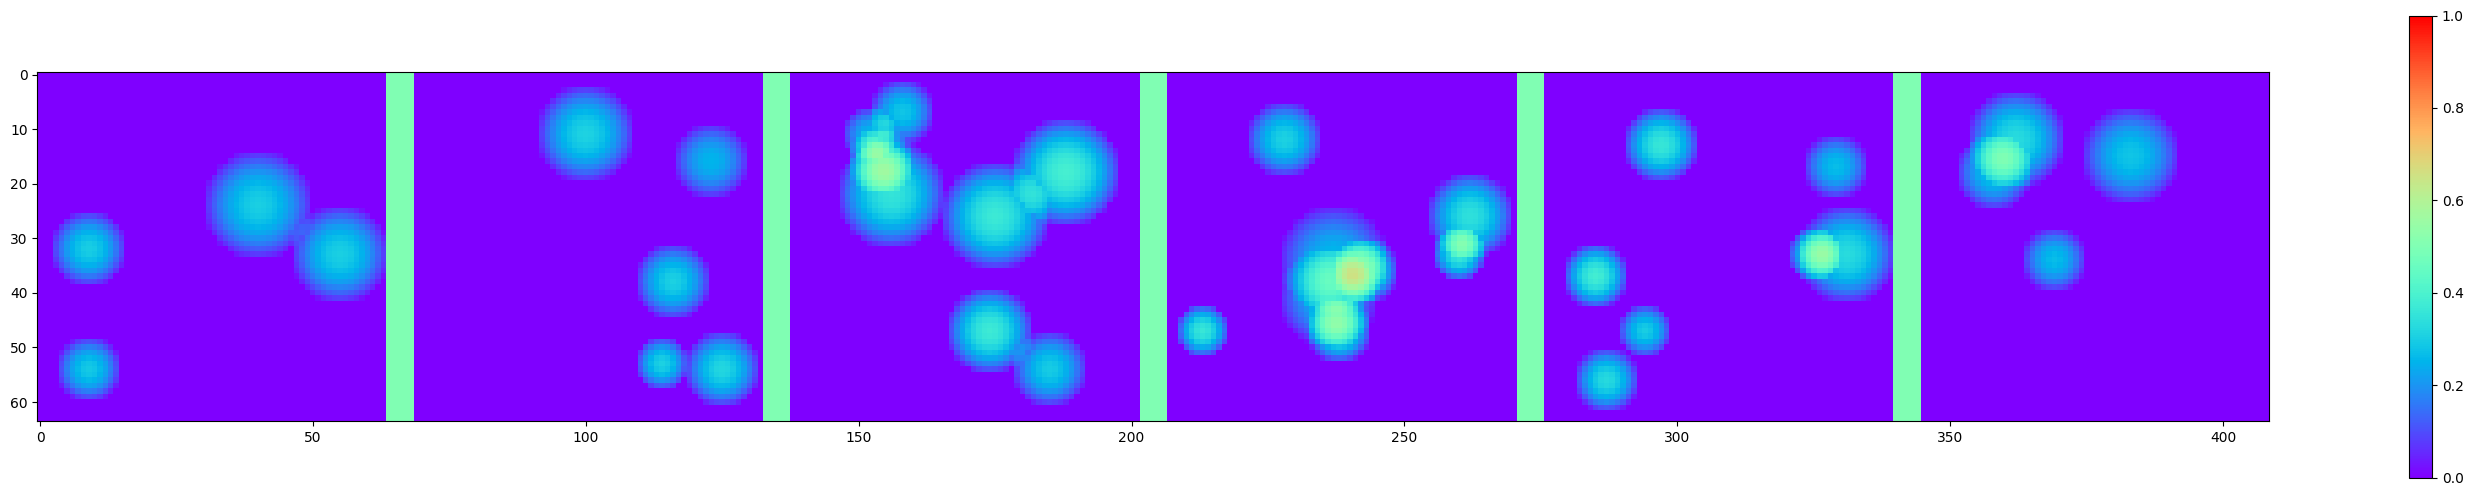

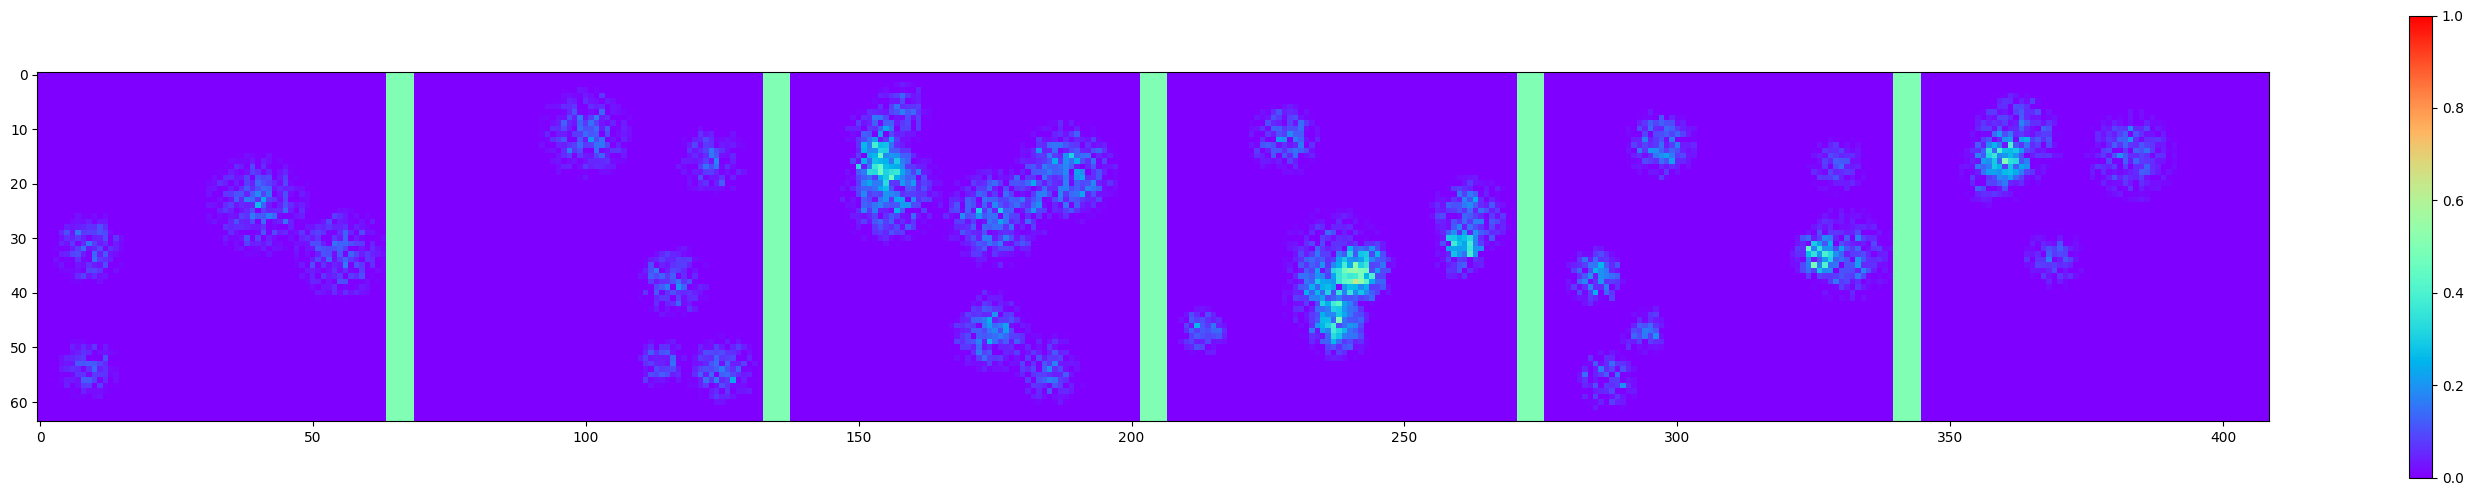

In [5]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y)$$
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

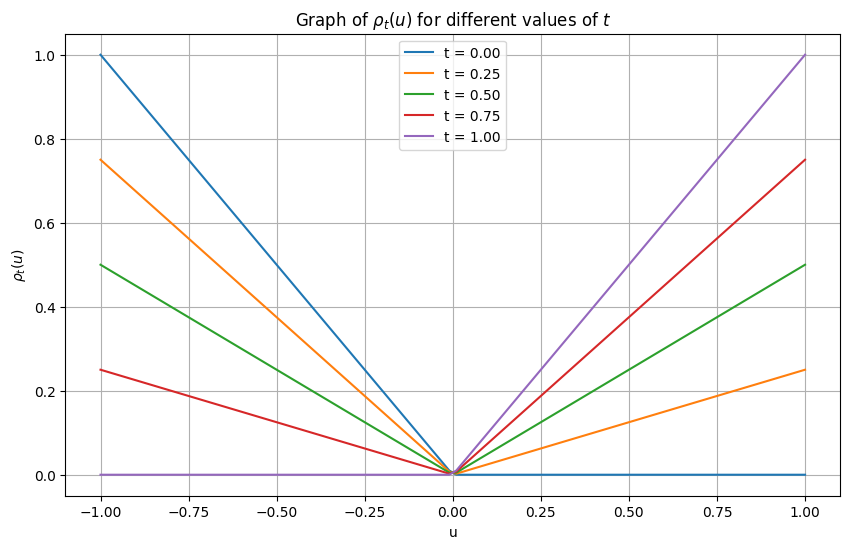

In [6]:
U = np.linspace(-1,1,100)
t_values= np.linspace(0,1,5)
def rho(u,t):
        return t * np.maximum(u, 0) + (t - 1) * np.minimum(u, 0)


rho_T = []
plt.figure(figsize=(10, 6))
for t in t_values :
  plt.plot(U,rho(U,t), label=f't = {t:.2f}')

plt.title(r'Graph of $\rho_t(u)$ for different values of $t$')
plt.xlabel('u')
plt.ylabel(r'$\rho_t(u)$')
plt.legend()
plt.grid(True)
plt.show()




One can show (see accompanying exercise sheet for the practical session) that the value of $z$ that minimizes the expectation $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , z) ]$ is the $t$-th quantile of the distribution of $y_{i,j}$.

In the context where the value $y_{i,j}$  depends on the image $x$, minimizing $\mathbb{E}_y [\mathcal{L}_t(y_{i,j} , f^\theta_{i,j}(x))]$ will therefore constrain the network $f^\theta$ to provide the $t$-th quantile of $p(y_{i,j} | x)$.

**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles.

In [7]:
t = 0.9

def rho(u,t):
        loss = t*u.clamp(min=0.) + (t-1)*u.clamp(max=0.)
        loss = loss.mean()
        return loss

def criterion(output, target):
  return rho(target-output, t)

**Q3** Train a U-Net to estimate the ninth decile.

In [8]:
#Importer d'abord le modele et l'optimizer


fcn = UNet(1,1,8)
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))



In [17]:
#The training loop
nepochs = 10
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses = []
    for i in range(nbatches):

        # Sampling (X,Y)
        input, target = gen_proba(batchsize)

        # Ensure input and target are on CPU (this is usually the default)
        # input = input.cuda() - Remove this line
        # target = target.cuda() - Remove this line

        # Forward
        optimizer.zero_grad()
        output = fcn(input)

        # Loss
        loss = criterion(output, target)

        # Gradients
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.item())  # Directly use .item() to get the loss value

        # No need to delete and empty cache since we're not using GPU
        # del target, input, loss
        # torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)


Epoch 0
epoch loss : 

0.003425985526992008
Epoch 1
epoch loss : 

0.0016836770216468722
Epoch 2
epoch loss : 

0.0014313891355413944
Epoch 3
epoch loss : 

0.0013770715426653624
Epoch 4
epoch loss : 

0.0013345537474378944
Epoch 5
epoch loss : 

0.001311588699463755
Epoch 6
epoch loss : 

0.001314617437310517
Epoch 7
epoch loss : 

0.0012980508850887417
Epoch 8
epoch loss : 

0.0013060050667263567
Epoch 9
epoch loss : 

0.001273629495408386


**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

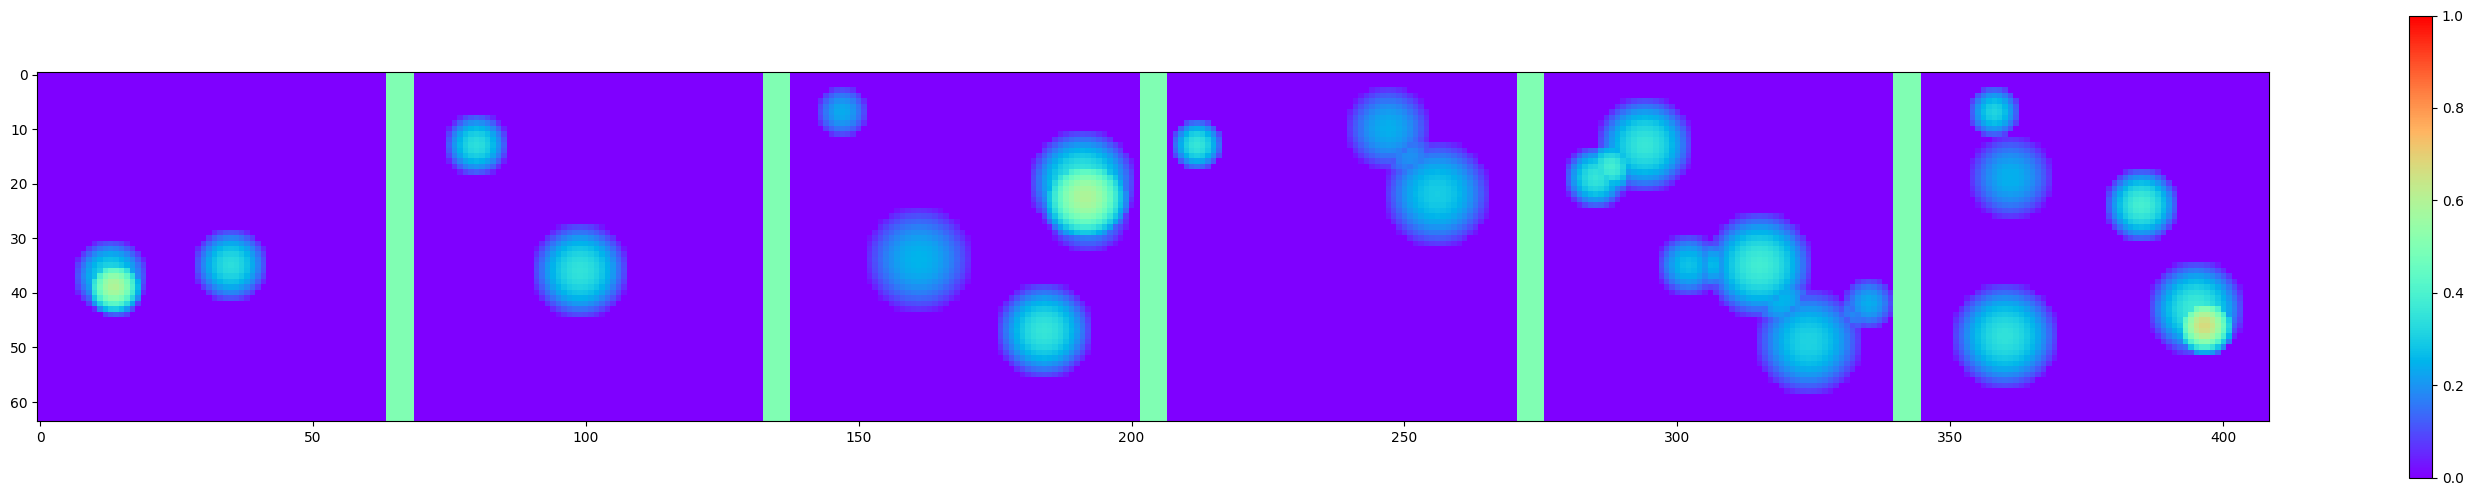

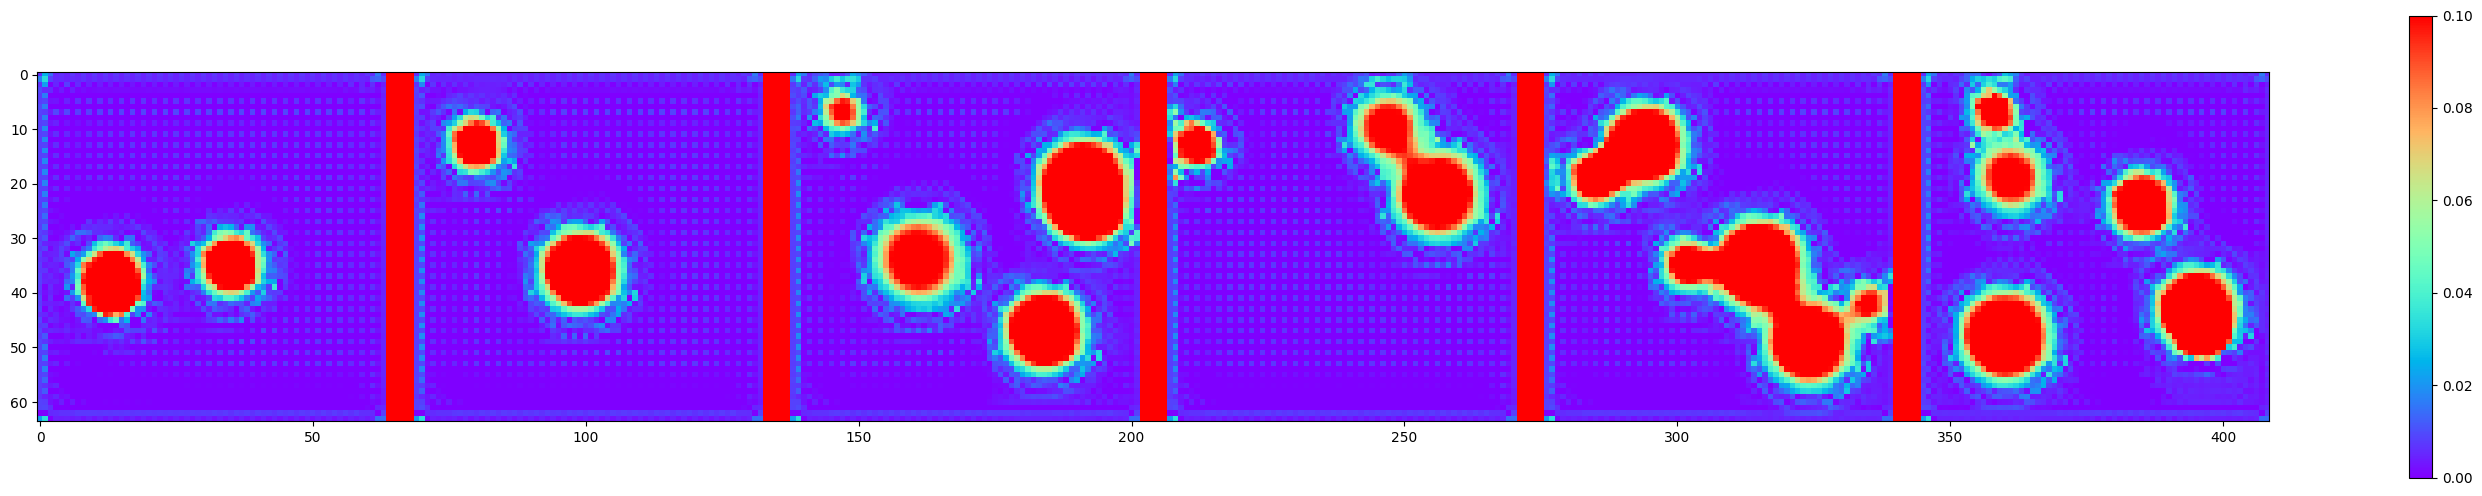

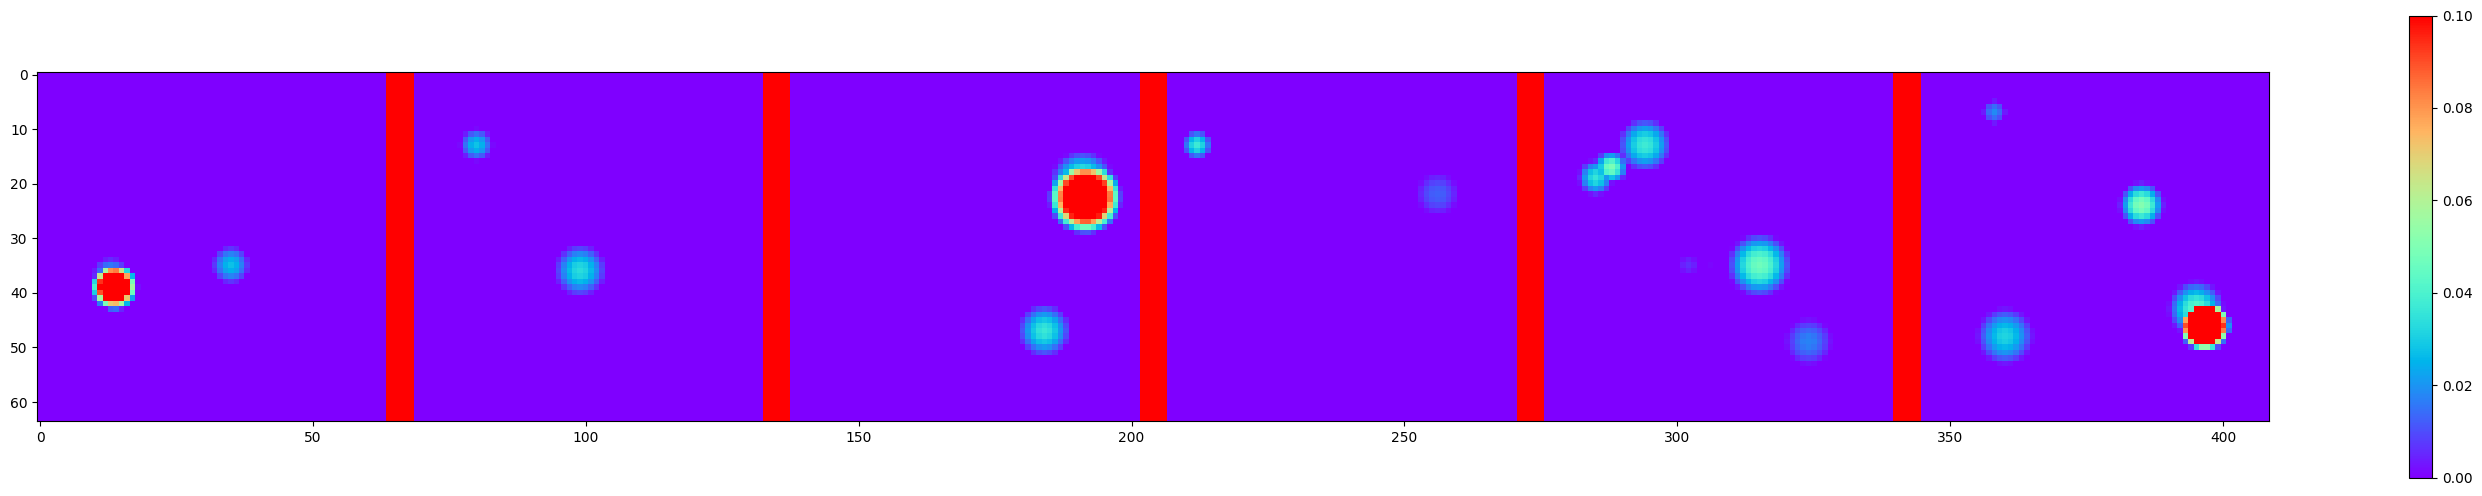

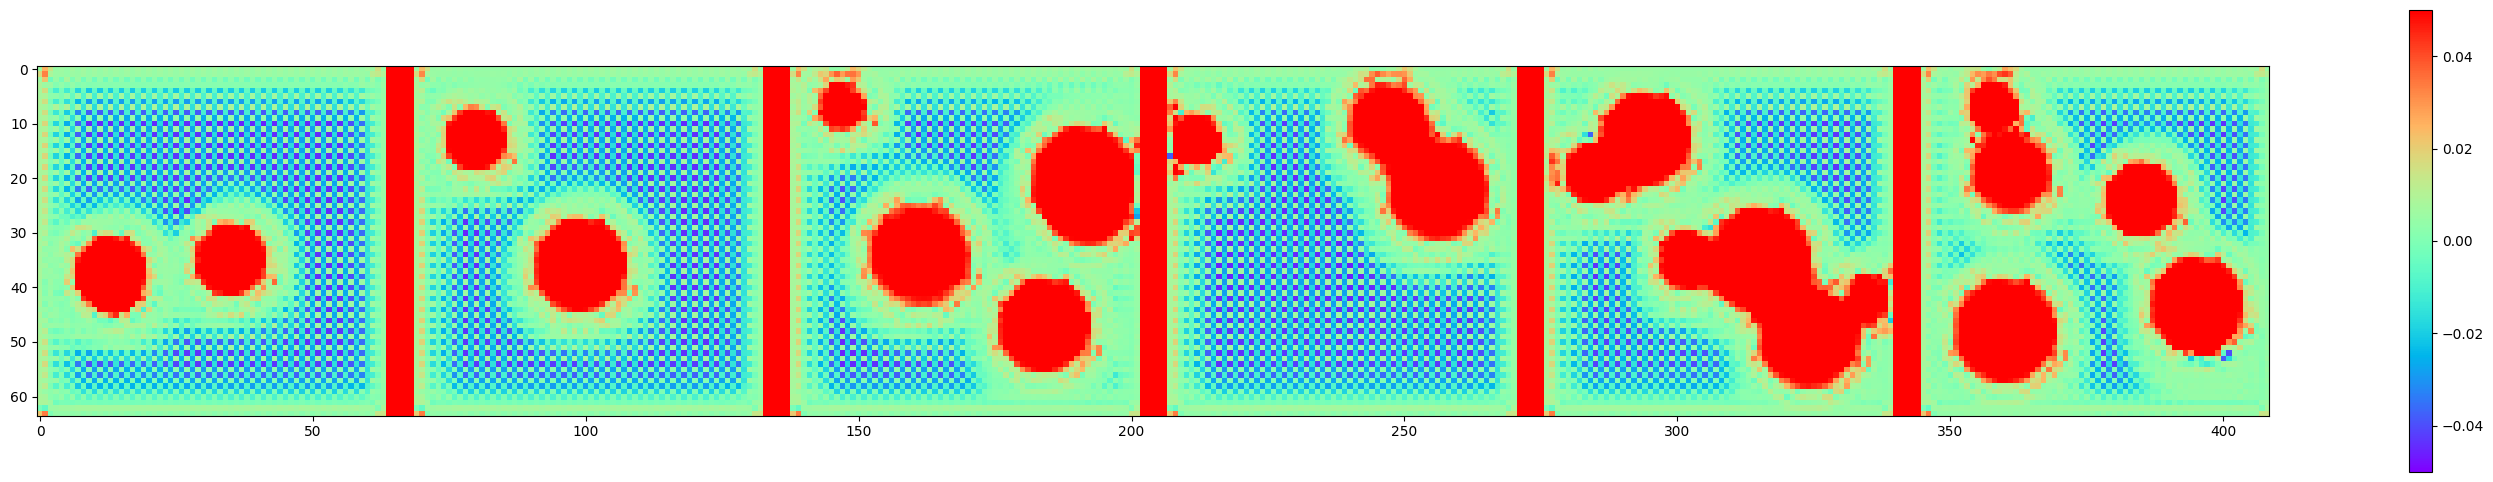

In [13]:
fcn.eval()
input, target = gen_proba(6)
output = fcn(input)
#Visualiser les inputs initiales

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) #Entrées: première ligne

#Visualiser les outputs du modele
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach(), 6, fig1, k=0, min_scale=0,max_scale=0.1) #Sorties: deuxième ligne

#Calcul du quantile
m = torch.distributions.normal.Normal(input**2, 0.2*input+0.000001, validate_args=None)
quantiles = m.icdf(0*input + 0.1)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) #Premier décile (ground truth)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - quantiles, 6, fig2, k=0, min_scale=-0.05,max_scale=0.05) #sorties - ground truth





**Exercise 2**: a trickier dependence

Let's now work with the *gen_proba_2* function. Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

In [15]:
def gen_proba_2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  m = torch.normal(2, 2. + target2)
  input = target1 + target2
  target =   m
  return  input, target

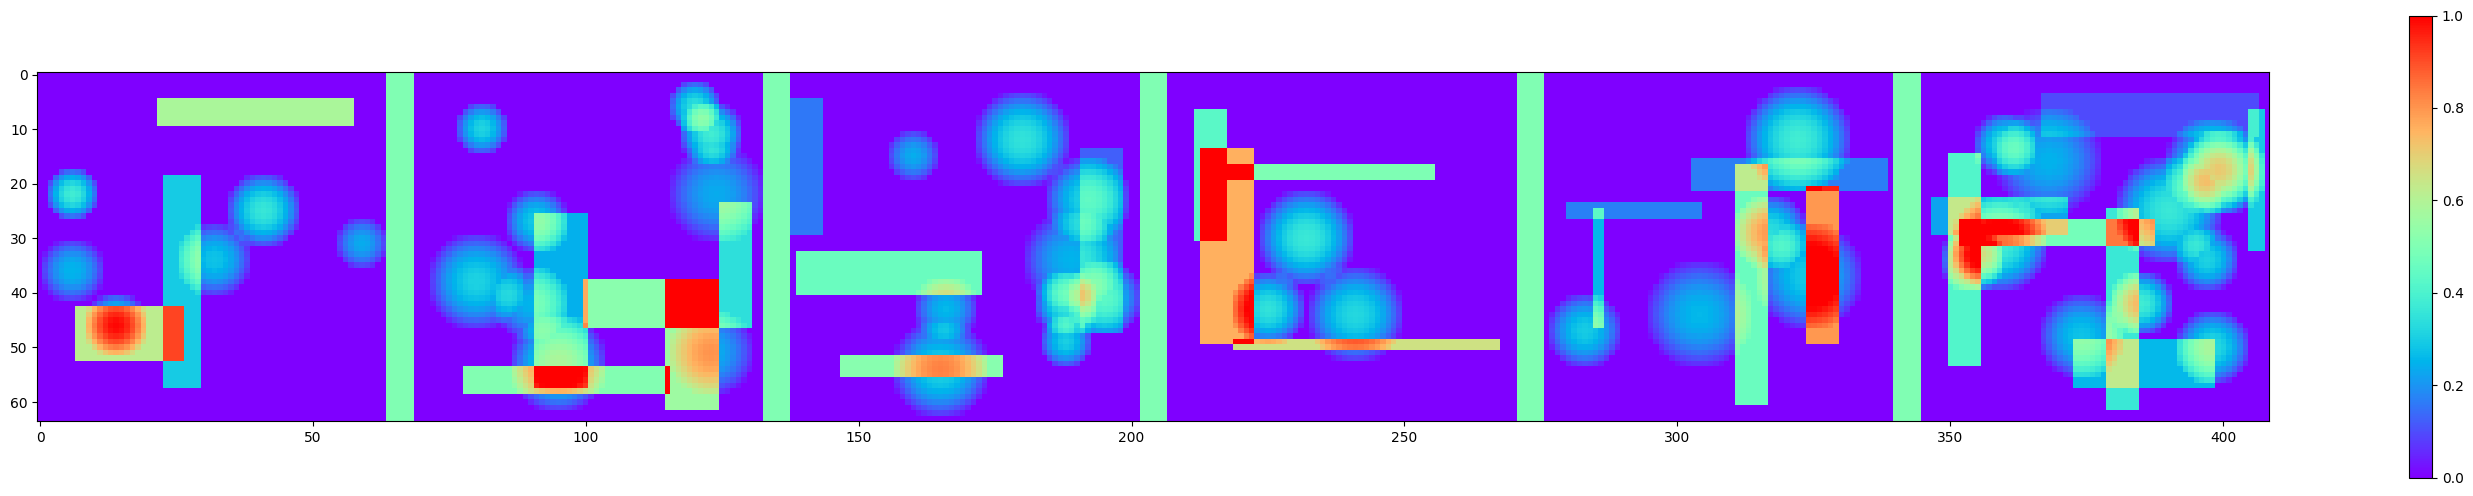

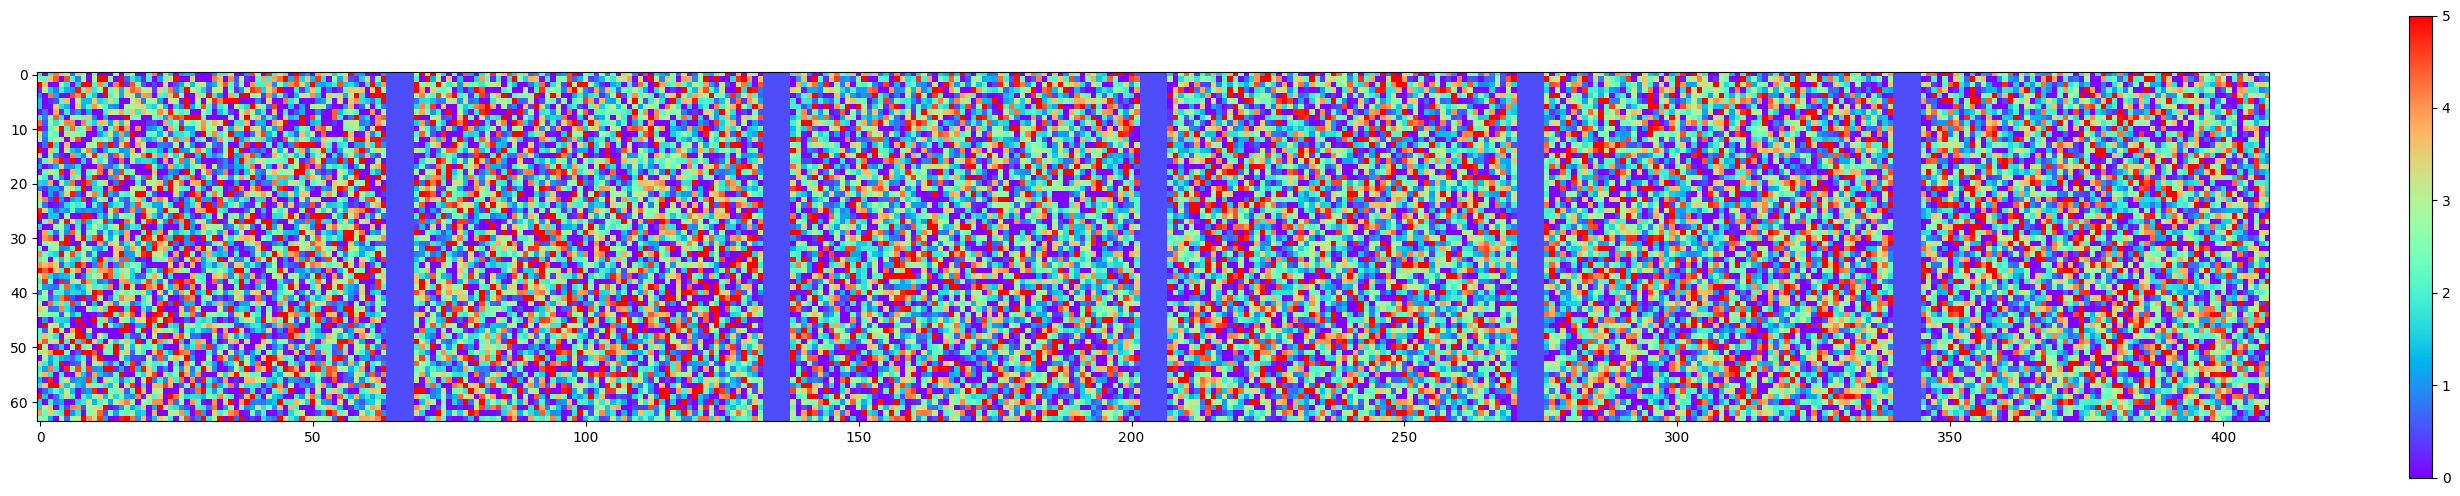

In [22]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

**Q2** Do we have a dependance ? Is it still a pixel-wise dependence (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)?

In [18]:
def criterion(output, target):
  return rho(target-output, 0.1)

In [19]:
#Estimation du quantile on commence d'abord par la training loop
#The training loop
nepochs = 10
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses = []
    for i in range(nbatches):

        # Sampling (X,Y)
        input, target = gen_proba(batchsize)

        # Ensure input and target are on CPU (this is usually the default)
        # input = input.cuda() - Remove this line
        # target = target.cuda() - Remove this line

        # Forward
        optimizer.zero_grad()
        output = fcn(input)

        # Loss
        loss = criterion(output, target)

        # Gradients
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.item())  # Directly use .item() to get the loss value

        # No need to delete and empty cache since we're not using GPU
        # del target, input, loss
        # torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)


Epoch 0
epoch loss : 

0.001611091608647257
Epoch 1
epoch loss : 

0.0014138574828393758
Epoch 2
epoch loss : 

0.0013933173450641333
Epoch 3
epoch loss : 

0.001356584916356951
Epoch 4
epoch loss : 

0.0013778583495877683
Epoch 5
epoch loss : 

0.0013679437770042569
Epoch 6
epoch loss : 

0.001344830896705389
Epoch 7
epoch loss : 

0.0013637974567245691
Epoch 8
epoch loss : 

0.0013544008776079862
Epoch 9
epoch loss : 

0.0013153587735723704


In [24]:
fcn.eval()
input, target = gen_proba_2(6)
output = fcn(input)

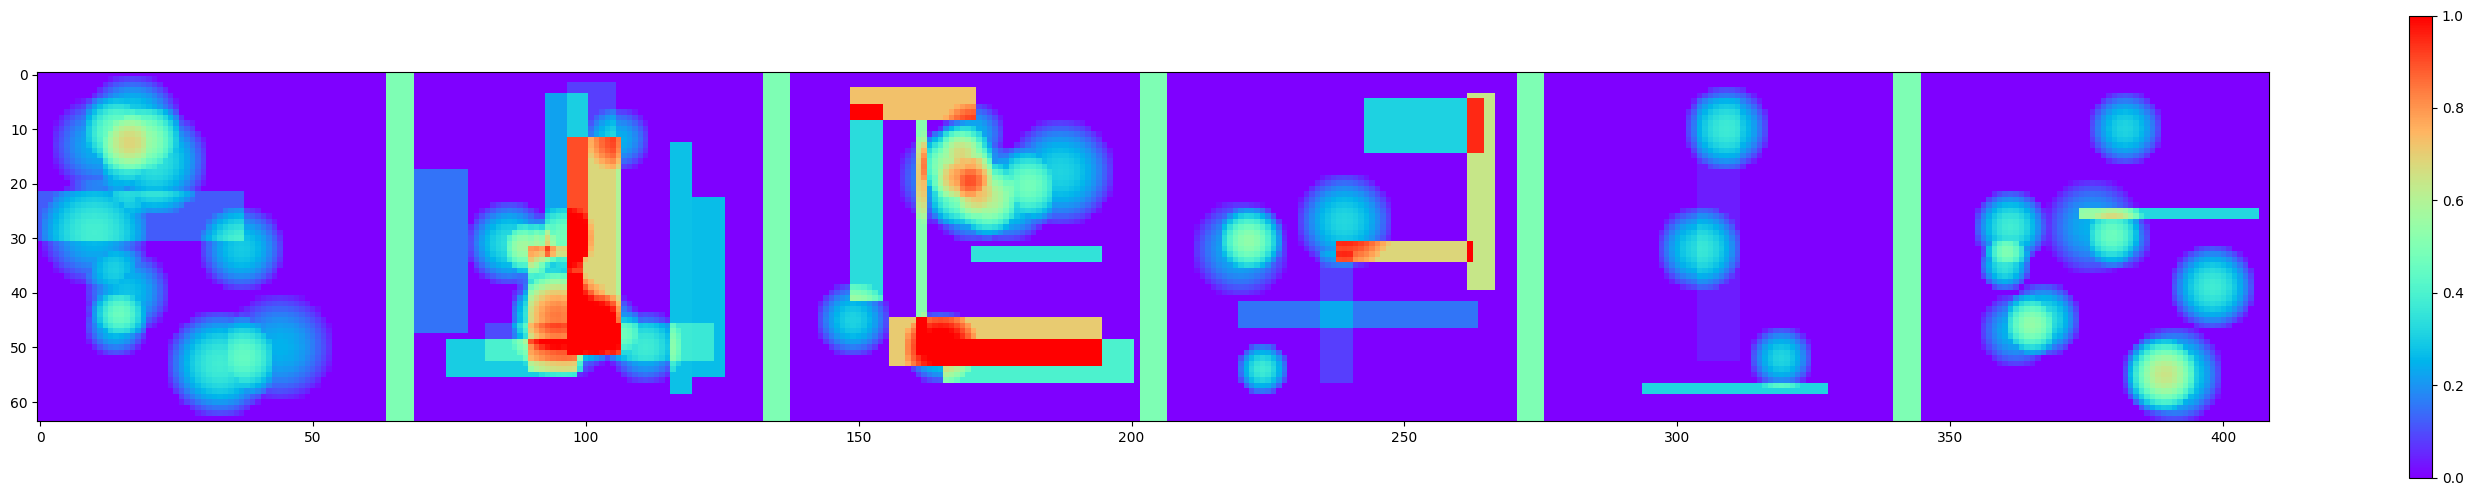

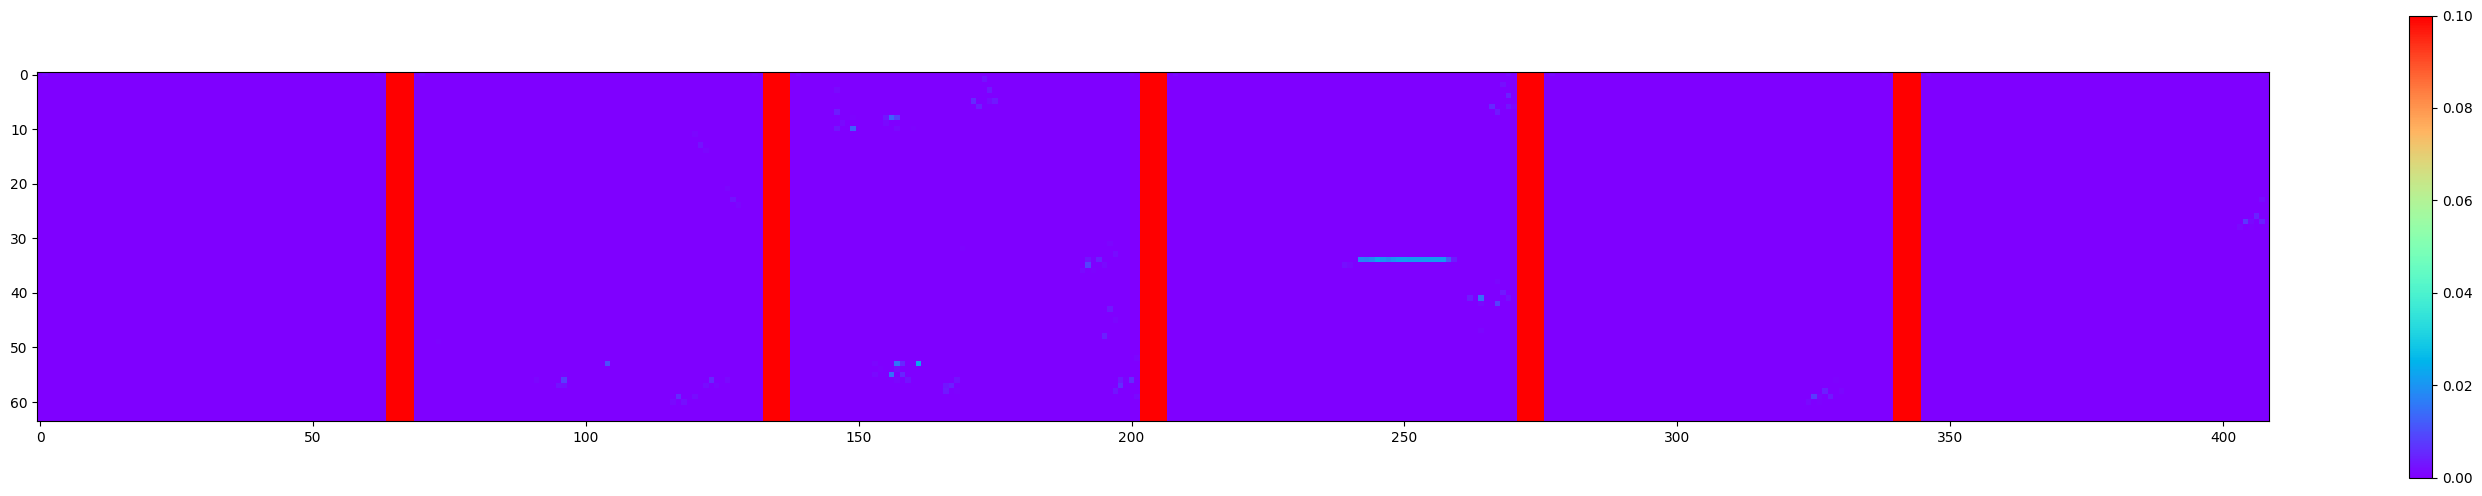

In [25]:
#Visualiser les inputs initiales

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) #Entrées: première ligne

#Visualiser les outputs du modele
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach(), 6, fig1, k=0, min_scale=0,max_scale=0.1) #Sorties: deuxième ligne


**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = ...

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        d = target.view(bs, 1, nx, ny) - output
        loss_by_pix = ...
        loss = ...

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.